<a href="https://colab.research.google.com/github/AmrMohamadSalah/Face-Recognition/blob/main/Assignement1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 from google.colab import drive  
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from PIL import Image
import numpy as np
import scipy
import matplotlib.pyplot as plt
from more_itertools import sort_together
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
def LoadDataset():
    image = Image.open('/content/gdrive/MyDrive/Dataset/s1/1.pgm')
    image_data = np.asarray(image)
    data = image_data.ravel()
    label = np.array([])
    for i in range(40):
        for j in range(10):
            image = Image.open(f'/content/gdrive/MyDrive/Dataset/s{i + 1}/{j + 1}.pgm')
            image_data = np.asarray(image)
            image_data = image_data.ravel()
            data = np.vstack([data, image_data])
            label = np.append(label, i + 1)
    data = np.delete(data, 0, axis=0)
    trainingData = data[1::2]
    trainingLabels = label[1::2]
    testingData = data[::2]
    testingLabels = label[::2]
    return trainingData, testingData, trainingLabels, testingLabels
def nonFaces(trainingFaces, testingFaces, num):
    image = np.array(Image.open(f'/content/gdrive/MyDrive/Non-Faces/Training/ (1).jpg').convert('L').resize((92, 112)))
    data = image.ravel()
    for i in range(2, num+1):
        image = np.array(Image.open(f'/content/gdrive/MyDrive/Non-Faces/Training/ ({i}).jpg').convert('L').resize((92, 112)))
        image = image.ravel()
        data = np.vstack([data, image])
    trainingData = np.append(trainingFaces, data, axis=0)

    image = np.array(Image.open(f'/content/gdrive/MyDrive/Non-Faces/Testing/ (1).jpg').convert('L').resize((92, 112)))
    data = image.ravel()
    for i in range(2, num+1):
        image = np.array(Image.open(f'/content/gdrive/MyDrive/Non-Faces/Testing/ ({i}).jpg').convert('L').resize((92, 112)))
        image = image.ravel()
        data = np.vstack([data, image])
    testingData = np.append(testingFaces, data,axis=0)

    trainingLabel = np.append(np.zeros(200), np.ones(num))
    testingLabel = trainingLabel.copy()

    return trainingData, testingData, trainingLabel, testingLabel

def PCA(trainingData, testingData, alpha):
    mean = np.mean(trainingData, axis=0)
    centeredData = trainingData - mean
    n = trainingData.shape[0]
    covarianceMat = n * np.dot(np.transpose(centeredData), centeredData)
    eigenValues, eigenVectors = np.linalg.eigh(covarianceMat)

    sum = np.sum(eigenValues)
    index = []
    n = len(alpha)
    value = eigenValues[-1]
    j = -1
    for i in range(n):
        expVar = value / sum
        while (expVar < alpha[i]):
            j = j - 1
            value = value + eigenValues[j]
            expVar = value / sum
        index.append(-j)

    n = len(alpha)
    proMat = []
    proTrainingData = []
    proTestingData = []
    for i in range(n):
        proMat.append(eigenVectors[:, range(-index[i], 0)])
        proTrainingData.append(np.dot(np.transpose(proMat[i]), np.transpose(trainingData)))
        proTestingData.append(np.dot(np.transpose(proMat[i]), np.transpose(testingData)))

    return proTrainingData, proTestingData
def KNN_LDA(trainingData, testingData, trainingLabel, testingLabel):
  k = [1, 3, 5, 7]
  acc = np.zeros(len(k))
  for i in range(len(k)):
      classifier = KNeighborsClassifier(n_neighbors=k[i])
      classifier.fit(np.transpose(trainingData), trainingLabel)
      predictedLabels = classifier.predict(np.transpose(testingData))
      acc[i] = accuracy_score(testingLabel, predictedLabels) * 100
      # print(f"Accuracy for k = {k[i]}: {acc[i]}\n")
  plt.plot(k, acc)
  plt.title("Faces-Non-Faces\n200-200\nKNN For LDA")
  plt.xlabel("K")
  plt.ylabel("Accuracy")
  plt.show()
  return acc
def KNN_PCA(trainingData, testingData, trainingLabel, testingLabel):
  k = [1, 3, 5, 7]
  alpha = [0.8, 0.85, 0.9, 0.95]
  acc = np.zeros((len(alpha),len(k)))
  for j in range(len(alpha)):
    for i in range(len(k)):
      classifier = KNeighborsClassifier(n_neighbors = k[i])
      classifier.fit(np.transpose(trainingData[j]), trainingLabel)  
      predictedLabels = classifier.predict(np.transpose(testingData[j]))
      acc[j][i] = accuracy_score(testingLabel, predictedLabels) * 100
      k = [1, 3, 5, 7]
    plt.plot(k, acc[j])
    plt.title(f"40 Faces\nKNN For PCA\nAlpha = {alpha[j]}")
    plt.xlabel("K")
    plt.ylabel("Accuracy")
    plt.show()
    # print(f"Accuracy for alpha = {alpha[j]} and k = {k[i]}: {acc[j][i]}\n")
  return acc
def LDA(trainingData, testingData, trainingLabel, testingLabel):
    mean = np.mean(trainingData, axis=0)
    classMean = []
    j = 0
    for i in range(40):
        classMean.append(np.mean(trainingData[j:j + 5, :], axis=0))
        j += 5
    classMean = np.array(classMean)
    # classMean = np.array([classMean])
    # Sb = np.dot(np.transpose(classMean[0]-mean), classMean[0]-mean)
    Sb = []
    Z = classMean[0] - mean
    Z = Z.reshape(-1, 1)
    Sb = (np.dot(Z, Z.transpose()))
    for i in range(1, 40):
        Z = classMean[i] - mean
        Z = Z.reshape(-1, 1)
        Sb += (np.dot(Z, Z.transpose()))
    Sb = np.array(Sb * 5)
    s = []
    j = 5
    s = np.dot(np.transpose(trainingData[0:5, :] - classMean[0]), trainingData[0:5, :] - classMean[0])
    for i in range(1, 40):
        s += np.dot(np.transpose(trainingData[j:j + 5, :] - classMean[i]), trainingData[j:j + 5, :] - classMean[i])
        j += 5
    Sinv = np.linalg.inv(s)
    c = np.dot(Sinv, Sb)
    eigenValues2, eigenVectors2 = np.linalg.eigh(c)
    # eigenValues2 = np.real(eigenValues2)
    # eigenVectors2 = np.real(eigenVectors2)
    eigenVal, eigenVec = sort_together([eigenValues2, eigenVectors2])
    eigenValues2 = np.array(eigenVal)
    eigenVectors2 = np.array(eigenVec)

    # sum = np.sum(eigenValues2)
    # value = eigenValues2[-1]
    # j = -1
    # expVar = value / sum
    # while (expVar < 0.9):
    #     j = j - 1
    #     value = value + eigenValues2[j]
    #     expVar = value / sum
    # index = -1 * j

    projMatrix = np.transpose(eigenVectors2[:, range(-39, 0)])
    projectedTrainD = np.dot(projMatrix, np.transpose(trainingData))
    projectedTestD = np.dot(projMatrix, np.transpose(testingData))
    return projectedTrainD, projectedTestD
def AccuracyReport(acc):
  plt.figure()
  acc_mean = np.mean(acc, axis = 1)
  plt.plot(alpha, acc_mean)
  plt.title("Faces-Non-Faces\n200-200\nKNN Mean of K Values")
  plt.xlabel("Alpha")
  plt.ylabel("Accuracy")
  plt.figure()
  acc_max = np.amax(acc, axis = 1)
  plt.plot(alpha, acc_max)
  plt.title("40 Faces\nKNN Max of K Values")
  plt.xlabel("Alpha")
  plt.ylabel("Accuracy")
  plt.show()

In [ ]:
trainingData, testingData, trainingLabels, testingLabels = LoadDataset()
alpha = [0.8, 0.85, 0.9, 0.95]

In [ ]:
proTrainingDataPCA, proTestingDataPCA = PCA(trainingData, testingData, alpha)

In [ ]:
proTrainingDataLDA, proTestingDataLDA = LDA(trainingData, testingData, trainingLabels, testingLabels)

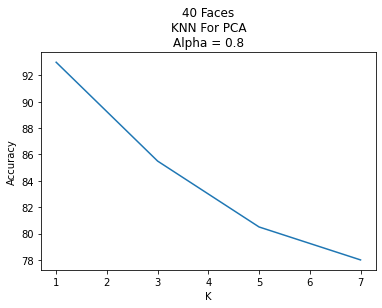

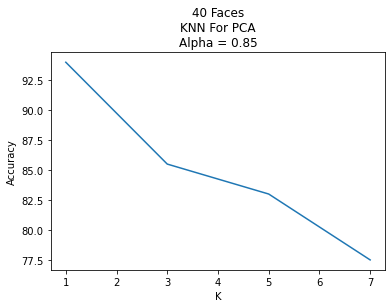

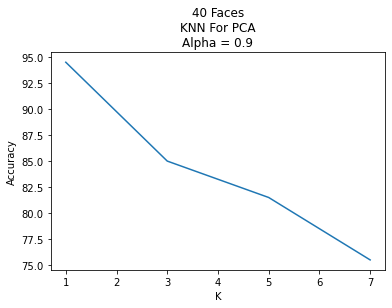

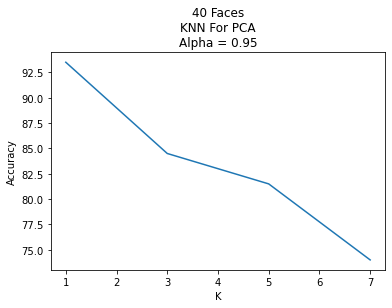

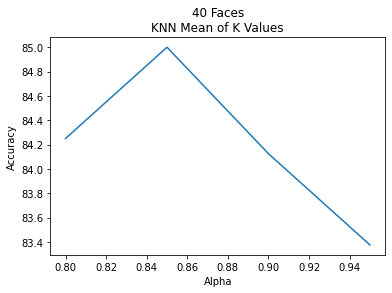

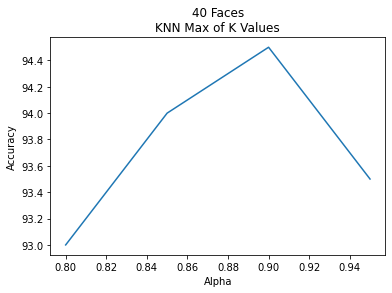

[[93.  85.5 80.5 78. ]
 [94.  85.5 83.  77.5]
 [94.5 85.  81.5 75.5]
 [93.5 84.5 81.5 74. ]]


In [ ]:
acc_PCA = KNN_PCA(proTrainingDataPCA, proTestingDataPCA,trainingLabels, testingLabels)
AccuracyReport(acc_PCA)
print(acc_PCA)

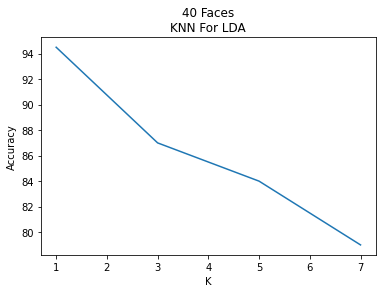

[94.5 87.  84.  79. ]


In [ ]:
acc_LDA = KNN_LDA(proTrainingDataLDA, proTestingDataLDA,trainingLabels, testingLabels)
print(acc_LDA)

In [ ]:
trainNFD,  testNFD, trainNFL, testNFL = nonFaces(trainingData, testingData, 200)

In [ ]:
protrainNFD, protestNFD = LDA(trainNFD, testNFD, trainNFL, testNFL)

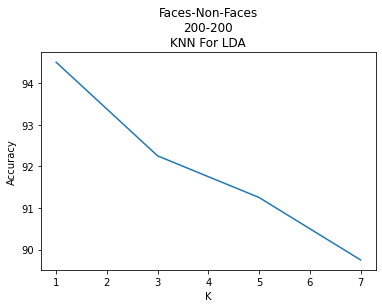

[94.5  92.25 91.25 89.75]


In [ ]:
acc_LDA = KNN_LDA(protrainNFD, protestNFD,trainNFL, testNFL)
print(acc_LDA)